# Задание

Вам предстоит поработать с данными о стабильности белков (`tm`). Нужно по последовательности белка и по `pH` предсказывать стабильность. Так как это дополнительное задание, то комментариев и подробного плана не будет, вам нужно максимально показать свои знания и постараться добиться наилучшего качества.

Небольшой план для начала:

1. Провести небольшой EDA, найти возможные выбросы и понять, в чем может быть дело.
2. Придумать, как закодировать аминокислотные последовательности в числовые векторы.
3. Разделить данные на `train` и `test` (подумать над правильной стратегией разбиения).
4. Используя кросс-вадидацию подобрать наилучшую модель на тренировочных данных.
5. Обучить лучшую модель на всех тренировочных данных.
5. Протестировать лучшую модель на тестовых данных.

Оформить подробный отчет в виде ноутбука. Постарайтесь воспользоваться всеми техниками, которые мы прошли в курсе.

*Так как текущее задание в довольно свободной форме, то четких критериев оценки нет. Если минимально проследовать вышеуказанным рекомендациям, то можно получить до **20 баллов**. Максимально за это задание можно получить **40***.

In [2]:
!nvidia-smi

Sat May 20 13:15:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from os.path import join
import pandas as pd
import seaborn as sns
import os
import glob

import numpy as np
import torch
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch.cuda as cuda

In [4]:
!wget https://raw.githubusercontent.com/danon6868/BI-ml-2023/main/additional_homework/data/data.csv

--2023-05-20 13:15:15--  https://raw.githubusercontent.com/danon6868/BI-ml-2023/main/additional_homework/data/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15460093 (15M) [text/plain]
Saving to: ‘data.csv.1’

data.csv.1          100%[===================>]  14.74M  --.-KB/s    in 0.07s   

2023-05-20 13:15:16 (203 MB/s) - ‘data.csv.1’ saved [15460093/15460093]



# EDA

In [5]:
data_folder = "./"
data_filename = "data.csv"
data_path = join(data_folder, data_filename)

In [6]:
data = pd.read_csv(data_path, index_col=0)
data.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [7]:
data.shape

(31390, 4)

In [8]:
data.describe()

,pH,tm
count,31104.000000,31390.000000
mean,6.892339,49.147337
std,1.612225,14.010089
min,1.990000,-1.000000
25%,7.000000,42.100000
50%,7.000000,48.000000
75%,7.000000,53.800000
max,64.900000,130.000000


Уже тут видим, что некоторые pH значения не заполнены

In [9]:
data[data.pH.isna()].head(10)

,protein_sequence,pH,data_source,tm
seq_id,,,,
484,ARINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,NaN,10.1016/j.jmb.2013.06.028,84.0
6215,MASHKLLVTPLKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,73.8
6216,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,85.5
6217,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,67.1
6218,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,83.2
6219,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,84.1
6220,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,84.4
6226,MASHKLLVTPPKALLKPLSIPNRLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,84.5
12926,MIRTGTQYLESLNDGRNVWVGNEKIDNVATHPKTRDYAQRHADFYD...,NaN,10.1002/cbic.201900413,50.0


Оставим только записи, в которых есть pH

In [10]:
data = data[~data.pH.isna()]

<Axes: xlabel='pH'>

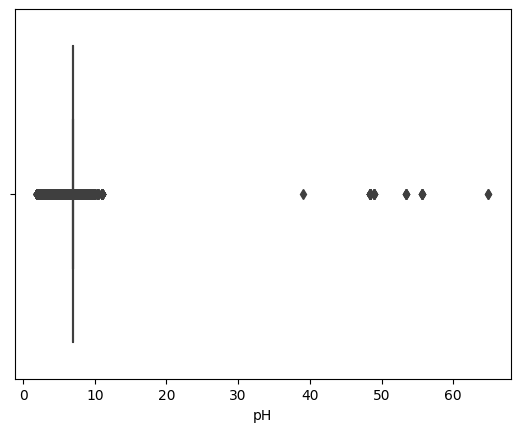

In [11]:
sns.boxplot(x=data.pH)

Избавимся от выбросов по pH. Более того, pH более 14 достаточно сложно интерпретировать, и не встречается в большинстве живих систем, где эти белки могут проявлять активность

In [12]:
data = data[data.pH<14]

<Axes: xlabel='pH'>

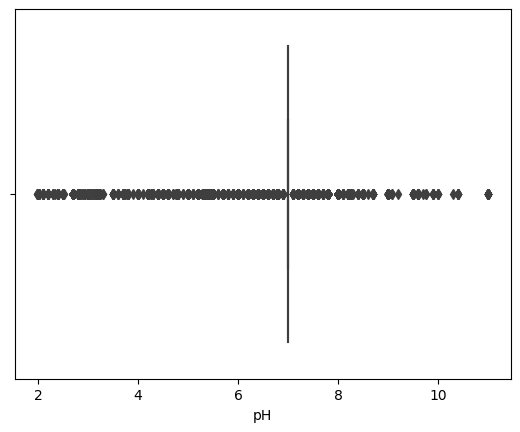

In [13]:
sns.boxplot(x=data.pH)

<Axes: xlabel='tm'>

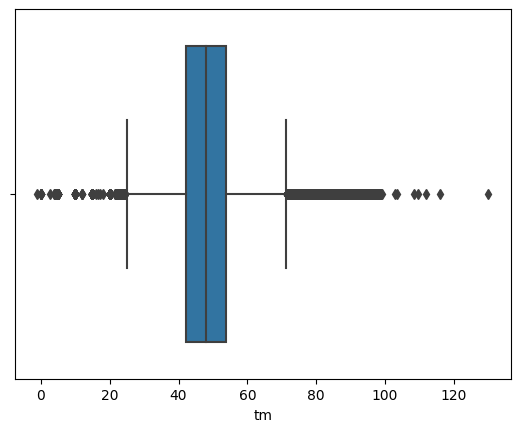

In [14]:
sns.boxplot(x=data.tm)

Посмотрим на длины последовательностей

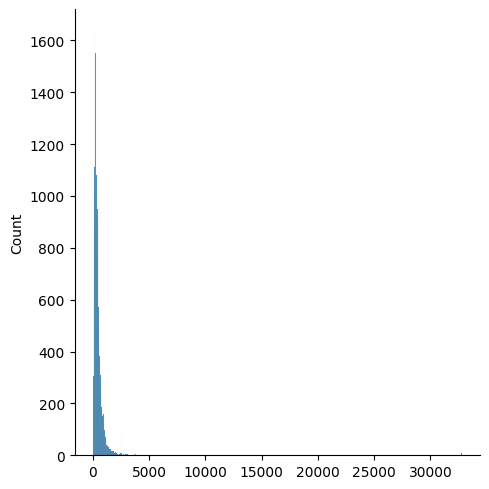

In [15]:
seq_lens = [len(seq) for seq in data.protein_sequence.unique()]
sns.displot(seq_lens)

Избавимся от очень длинных последовательностей, тк их очень мало и они могут сильно повлиять на работу модели

In [16]:
# сколько записей уберём из наших данных
(data.protein_sequence.apply(lambda x: len(x)) > 3000).sum()

93

In [17]:
data = data[data.protein_sequence.apply(lambda x: len(x)) < 3000]

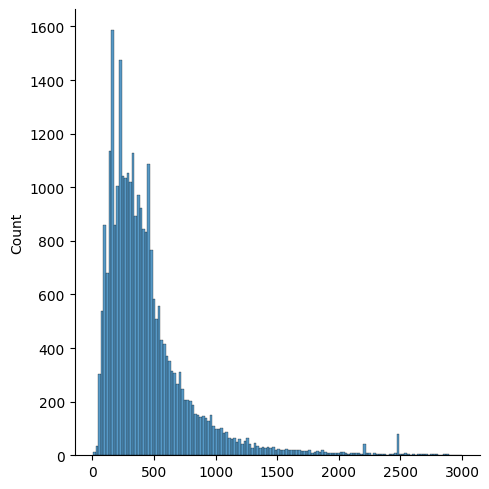

In [18]:
seq_lens = [len(seq) for seq in data.protein_sequence.unique()]
sns.displot(seq_lens)

Уберём ещё последовательностей, который длиннее 2000

In [19]:
data = data[data.protein_sequence.apply(lambda x: len(x)) < 2000]

In [20]:
data = data.loc[data.protein_sequence.apply(lambda x: len(x)).sort_values().index]

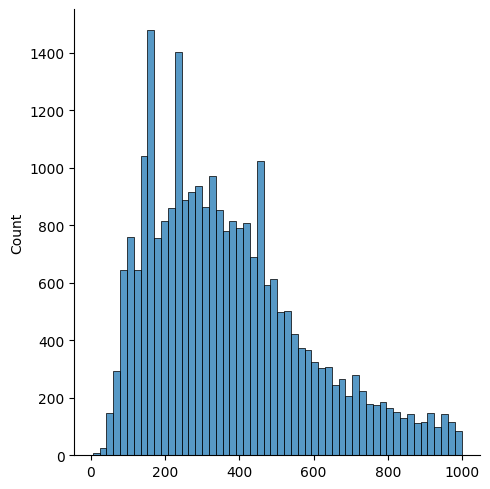

In [21]:
seq_lens = [len(seq) for seq in data.protein_sequence.unique()]
sns.displot(seq_lens)

In [22]:
data_df = data.reset_index(drop=True)
data_df

,protein_sequence,pH,data_source,tm
0,RPGSI,7.0,doi.org/10.1038/s41592-020-0801-4,49.2
1,RPAVT,7.0,doi.org/10.1038/s41592-020-0801-4,50.4
2,TVIHLVG,7.0,doi.org/10.1038/s41592-020-0801-4,44.4
3,LVVGTALNYINIF,7.0,doi.org/10.1038/s41592-020-0801-4,58.3
4,SCQGTGKDSHSFSS,7.0,doi.org/10.1038/s41592-020-0801-4,37.7
...,...,...,...,...
28998,MPVFHTKTIENILEPVAQQVSRLVILHEEANDGNAMPDLTGPVGMV...,7.0,doi.org/10.1038/s41592-020-0801-4,42.9
28999,MFPNQNNGAAPGQGPAVDGQQSLNYNGLPAQQQQQLAQSTKNVRKK...,7.0,doi.org/10.1038/s41592-020-0801-4,42.2
29000,MLEARVDMLSSNMIISGPAADLGAKEASRPWKKQLNSVPNSGPSAR...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
29001,MPLRLDVKRKLLARSDRVKCVDLHPVETWLLAALYNGNVHIWNYET...,7.0,doi.org/10.1038/s41592-020-0801-4,44.9


# AA to numbers

Воспользуемся автоэнкодером

In [25]:
def get_esm_embeddings(model, alphabet, batch_converter, data, device):
    gc.collect()
    model.eval()
    model.to(device)
    
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    batch_tokens = batch_tokens.to(device)
    
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]
    
    sequence_representations = []
    for i, tokens_len in enumerate(batch_lens):
        sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0).to("cpu").numpy())
        
    del batch_tokens
    del results
    del token_representations
    return sequence_representations

In [26]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")

Using cache found in /root/.cache/torch/hub/facebookresearch_esm_main


In [27]:
data_list = [(f"protein_{i}", data_df["protein_sequence"][i]) for i in range(data_df.shape[0])]

In [29]:
batch_converter = alphabet.get_batch_converter()
batch_size = 1
num_iter = np.ceil(len(data_list) / batch_size).astype(int)
sequence_embeddings = []

for i in tqdm(range(28570, num_iter)):
    sequence_representations = get_esm_embeddings(model,
                                                  alphabet,
                                                  batch_converter,
                                                  data_list[i*batch_size:(i+1)*batch_size],
                                                  device="cpu")
    
    sequence_embeddings += sequence_representations
    # cuda.empty_cache()

 98%|█████████▊| 23577/24003 [1:40:32<01:48,  3.91it/s]


OutOfMemoryError: ignored

In [30]:
sequence_embeddings_np = np.array(sequence_embeddings)

In [48]:
sequence_embeddings_np

array([[-0.01377406,  0.00222562, -0.01108639, ..., -0.11116361,
        -0.03306694,  0.07505599],
       [-0.02026508,  0.00477056, -0.01226092, ..., -0.10461603,
        -0.03129636,  0.07394806],
       [ 0.01511449, -0.02871362, -0.0585584 , ..., -0.18329369,
        -0.02070836,  0.11021607],
       ...,
       [ 0.04825787, -0.14706023, -0.03766372, ..., -0.1926396 ,
         0.12225787,  0.12285866],
       [ 0.03428208, -0.07955191, -0.04009968, ..., -0.11204869,
        -0.00390768,  0.1412542 ],
       [ 0.00320925, -0.09455954,  0.01011417, ..., -0.11876332,
         0.06970718,  0.09641735]], dtype=float32)

In [31]:
sequence_embeddings_np.tofile('2_embeddings_5000_28577.txt')

# PCA check

# Train-test split

Загрузим дампы итераций расчёта эмбеддингов

In [ ]:
data_pre_list = []
embeddings_pre_list = []

for path in glob.glob('*_embeddings_*.txt'):
  print(path)
  tmp_parse = path[:-4].split('_')
  start, end = int(tmp_parse[-2]), int(tmp_parse[-1])
  tmp_np = np.fromfile(path, dtype='float32')
  tmp_np = tmp_np.reshape(end-start, 1280)

  embeddings_pre_list.append(tmp_np)
  data_pre_list.append(data_df.iloc[start:end])

data_df_new = pd.concat(data_pre_list)

embeddings = np.concatenate(
    (
        np.concatenate(embeddings_pre_list, axis=0),
        data_df_new[['pH']].values
     ), axis=1
     )

Очевидно, что нам нужно положить измерения для одного и того же белка либо в train, либо в test

In [52]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm

In [42]:
def custom_train_test_split(data_df, embeddings, test_size=0.2, random_state=42):

  data_cumsum = data_df.protein_sequence.value_counts().sample(frac=1, random_state=random_state).cumsum()
  test_proteins = data_cumsum[data_cumsum<test_size*data_cumsum[-1]].index
  test_mask = data_df.protein_sequence.isin(test_proteins)

  X_test = embeddings[test_mask]
  X_train = embeddings[~test_mask]
  y_test = data_df.tm[test_mask].values
  y_train = data_df.tm[~test_mask].values

  return X_train, X_test, y_train, y_test

In [43]:
X_train, X_test, y_train, y_test = custom_train_test_split(data_df_new, embeddings)

In [44]:
X_train.shape

(18862, 1281)

# Model train

## LGBMRegressor

Обучим регрессор LGBMRegressor, подобрав оптимальные параметры с помощью GridSearchCV

In [45]:
params = {"num_leaves": [20, 31, 40, 50], 'max_depth': [-1,15, 20, 30, 50], 'n_estimators': [50, 100, 200, 300, 400]}

lgbm_model = lightgbm.LGBMRegressor(random_state=42)

rf_search = GridSearchCV(lgbm_model, params, scoring = 'neg_mean_squared_error', cv = 5, n_jobs=-1)

rf_search.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
max(rf_search.cv_results_['mean_test_score'])

In [ ]:
rf_search.best_params_

In [49]:
model = lightgbm.LGBMRegressor(random_state=42,
    #                            n_jobs=20, max_depth = -1,
    # n_estimators = 200, num_leaves = 31
    ).fit(X_train, y_train)

In [50]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [53]:
metric_train = mean_squared_error(y_train, y_train_pred)
metric_test = mean_squared_error(y_test, y_test_pred)

In [54]:
print(f'{metric_train=}', f'{metric_test=}')

metric_train=34.178870516805205 metric_test=52.47469469994269


In [55]:
import matplotlib.pyplot as plt

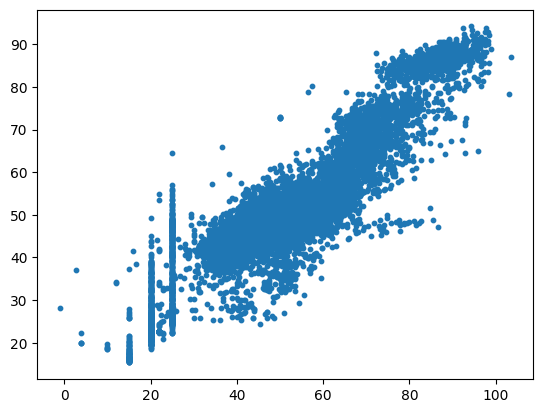

In [58]:
plt.scatter(y_train, y_train_pred, s=10)

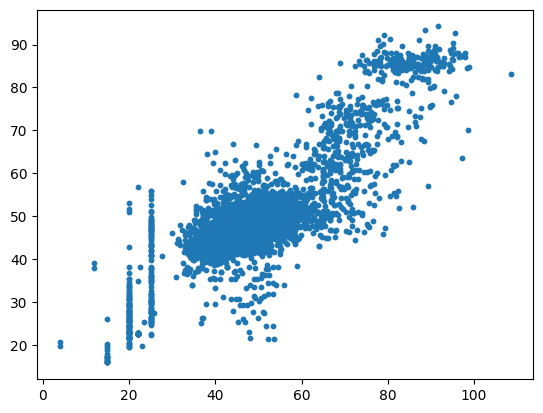

In [57]:
plt.scatter(y_test, y_test_pred, s=10)

## linear regression